# PV China 2020 Dataset

This dataset maps the distribution of photovoltaic (PV) solar power installations across China as of *2020*. It was generated using a pixel-based **Random Forest classifier** applied to **Landsat 8 Surface Reflectance** products, with all processing conducted on **Google Earth Engine (GEE)**.

This dataset and its methodology are described in the following paper:

> **Huang, Y., Liu, J., Xu, Y. et al. (2022)**  
> *A high-resolution inventory of photovoltaic power installations in China.*  
> *Earth System Science Data*, **14**, 2839–2854.  
> [https://doi.org/10.5194/essd-14-2839-2022](https://doi.org/10.5194/essd-14-2839-2022)

The dataset is publicly available on **Zenodo**:
> [PV_China_2020 on Zenodo (Record #6849477)](https://zenodo.org/record/6849477)

# Setup

In [3]:
import os
import zipfile
import requests
import geopandas as gpd
import plotly.express as px

## Download

In [4]:
url = "https://zenodo.org/record/6849477/files/PV_China_2020.zip?download=1"

# Output folder
output_folder = os.path.join("..", "..", "data", "raw_data", "pv_china_2020")
os.makedirs(output_folder, exist_ok=True)

zipname = "pv_china_2020.zip"
zippath = os.path.join(output_folder, zipname)

# Download the file
print("Downloading dataset...")
response = requests.get(url)
with open(zippath, "wb") as f:
    f.write(response.content)
print("✅ Downloaded:", {zippath})

# Extract files
print("Extracting files...")
with zipfile.ZipFile(zippath, 'r') as zip_ref:
    zip_ref.extractall(output_folder)
os.remove(zippath)
print(f"Deleted zip file: {zipname}")

# List extracted files
print("Extracted files:", os.listdir(output_folder))


✅ Downloaded: {'..\\..\\data\\raw_data\\pv_china_2020\\pv_china_2020.zip'}
Extracting files...
Deleted zip file: pv_china_2020.zip
Extracted files: ['PV_China_2020.cpg', 'PV_China_2020.dbf', 'PV_China_2020.prj', 'PV_China_2020.shp', 'PV_China_2020.shx']


## Clean

In [5]:
gdf = gpd.read_file("../../data/raw_data/pv_china_2020/PV_China_2020.shp")

gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2539 entries, 0 to 2538
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   OBJECTID   2539 non-null   int32   
 1   landcover  2539 non-null   int32   
 2   area       2539 non-null   float64 
 3   temp       2539 non-null   float64 
 4   precip     2539 non-null   float64 
 5   elev       2539 non-null   float64 
 6   popu       2539 non-null   int64   
 7   EVI_2013   2539 non-null   float64 
 8   EVI_2020   2539 non-null   float64 
 9   lat_centr  2539 non-null   float64 
 10  lon_centr  2539 non-null   float64 
 11  geometry   2539 non-null   geometry
dtypes: float64(8), geometry(1), int32(2), int64(1)
memory usage: 218.3 KB


In [6]:
gdf.head()

,OBJECTID,landcover,area,temp,precip,elev,popu,EVI_2013,EVI_2020,lat_centr,lon_centr,geometry
0,1050,40,0.63673,15.8,1160.2,87.8,240,0.426,0.326,31.539895,113.987199,"MULTIPOLYGON (((113.98 31.54, 113.98 31.541, 1..."
1,547,60,1.52337,9.6,170.1,256.5,9,0.096,0.095,44.929143,82.596528,"POLYGON ((82.585 44.924, 82.585 44.926, 82.586..."
2,966,80,0.49803,17.5,1665.0,4.4,640,0.155,0.232,29.505017,121.665288,"MULTIPOLYGON (((121.65 29.502, 121.65 29.503, ..."
3,1078,40,1.07808,17.0,1226.4,82.5,281,0.399,0.293,30.819104,112.938832,"MULTIPOLYGON (((112.92 30.822, 112.92 30.823, ..."
4,634,40,1.10933,6.6,425.5,181.3,42,0.244,0.183,45.226290,121.945304,"POLYGON ((121.94 45.22, 121.94 45.22, 121.94 4..."


In [7]:
# Check current CRS
print(gdf.crs)

EPSG:4326


EPSG:4326 is a geographic CRS — it uses latitude and longitude in degrees

### Find the province

We aim to focus exclusively on mainland China. To ensure a fair and consistent comparison, we will remove data related to Taiwan.

Approximate lat/lon ranges for Taiwan:
- Latitude: 21.5 to 25.5
- Longitude: 119.5 to 122.5


In [8]:
gdf = gdf[~(
    (gdf['lat_centr'] >= 21.5) & (gdf['lat_centr'] <= 25.5) &
    (gdf['lon_centr'] >= 119.5) & (gdf['lon_centr'] <= 122.5)
)]

In [9]:
gadm = gpd.read_file("../../data/data_processed/mapdata/gadm41_CHN_3_processed.json")
gdf = gdf.to_crs(gadm.crs)

joined_within = gpd.sjoin(gdf, gadm[["Province", "Prefecture", "County", "geometry"]], how="left", predicate="within")

joined_within.head()


,OBJECTID,landcover,area,temp,precip,elev,popu,EVI_2013,EVI_2020,lat_centr,lon_centr,geometry,index_right,Province,Prefecture,County
0,1050,40,0.63673,15.8,1160.2,87.8,240,0.426,0.326,31.539895,113.987199,"MULTIPOLYGON (((113.98 31.54, 113.98 31.541, 1...",967.0,Hubei,SuizhouShi,Yingshan
1,547,60,1.52337,9.6,170.1,256.5,9,0.096,0.095,44.929143,82.596528,"POLYGON ((82.585 44.924, 82.585 44.926, 82.586...",2081.0,Xinjiang,BörtalaMongol,Bole
2,966,80,0.49803,17.5,1665.0,4.4,640,0.155,0.232,29.505017,121.665288,"MULTIPOLYGON (((121.65 29.502, 121.65 29.503, ...",2385.0,Zhejiang,Ningbo,Xiangshan
3,1078,40,1.07808,17.0,1226.4,82.5,281,0.399,0.293,30.819104,112.938832,"MULTIPOLYGON (((112.92 30.822, 112.92 30.823, ...",946.0,Hubei,Jingmen,Jingshan
4,634,40,1.10933,6.6,425.5,181.3,42,0.244,0.183,45.226290,121.945304,"POLYGON ((121.94 45.22, 121.94 45.22, 121.94 4...",NaN,NaN,NaN,NaN


In [10]:
joined_within = joined_within.drop('index_right', axis = 1)

In [ ]:
joined_within.isna().sum()

OBJECTID        0
landcover       0
area            0
temp            0
precip          0
elev            0
popu            0
EVI_2013        0
EVI_2020        0
lat_centr       0
lon_centr       0
geometry        0
Province      254
Prefecture    254
County        254
dtype: int64

In [12]:
# Identify unmatched features
null_idx = joined_within[joined_within['Province'].isna()].index
null_features = gdf.loc[null_idx]

In [13]:
# Plot to see common points between unmatched features
unmatched = joined_within[joined_within['Province'].isna()]

fig = px.scatter_map(
    unmatched,
    lat="lat_centr",
    lon="lon_centr",
    hover_data={"lat_centr": True, "lon_centr": True},
    color_discrete_sequence=["red"],  
    zoom=4,
    height=600,
    width=800,
)

fig.update_layout(
    mapbox_style="open-street-map", 
    margin={"r":0,"t":30,"l":0,"b":0},
    showlegend=False,
)

fig.show()

Some provinces have `null` values after the spatial join because their geometries do not fully contain the points or polygons from the original dataset. This can happen if the features lie exactly on the boundary between provinces (see the map) because `within` excludes points that are only touching but not fully inside a province polygon..

Thus for unmatched fatures, we can do an `intersect` join to faind all provinces that touch them and then choose the province with the largest overlapping area proportion as the "main province". For any features still unmatched, assign the nearest province.

In [14]:
intersects = gpd.sjoin(null_features, gadm[['Province', 'Prefecture','County', 'geometry']], how='left', predicate='intersects')
intersects.head()

,OBJECTID,landcover,area,temp,precip,elev,popu,EVI_2013,EVI_2020,lat_centr,lon_centr,geometry,index_right,Province,Prefecture,County
4,634,40,1.10933,6.6,425.5,181.3,42,0.244,0.183,45.226290,121.945304,"POLYGON ((121.94 45.22, 121.94 45.22, 121.94 4...",1481.0,Inner Mongolia,Xing'an,HorqinRightMiddle
4,634,40,1.10933,6.6,425.5,181.3,42,0.244,0.183,45.226290,121.945304,"POLYGON ((121.94 45.22, 121.94 45.22, 121.94 4...",1483.0,Inner Mongolia,Xing'an,Tuquan
11,1457,40,1.01549,8.5,548.4,765.5,203,0.347,0.230,38.560265,112.838878,"POLYGON ((112.83 38.562, 112.83 38.563, 112.83...",1861.0,Shanxi,Xinzhou,Xinfu
11,1457,40,1.01549,8.5,548.4,765.5,203,0.347,0.230,38.560265,112.838878,"POLYGON ((112.83 38.562, 112.83 38.563, 112.83...",1851.0,Shanxi,Xinzhou,Dingxiang
15,2014,40,2.51504,17.4,1617.2,0.0,1097,0.236,0.141,30.327253,120.816199,"MULTIPOLYGON (((120.78 30.317, 120.78 30.318, ...",NaN,NaN,NaN,NaN


Geographic coordinates (like latitude and longitude in EPSG:4326) represent locations on a curved surface (the Earth), which means calculations of area or distance directly on these coordinates are often inaccurate. To perform precise spatial operations such as measuring areas or calculating overlaps, geometries need to be transformed into a projected coordinate reference system (CRS). A projected CRS translates the curved Earth surface onto a flat plane, using units like meters, allowing for accurate measurement and spatial analysis. In this case, reprojecting to EPSG:32650 (a UTM zone) ensures that area calculations reflect real-world sizes, making the overlap proportion meaningful and reliable.

In [15]:
# Reproject both datasets to a projected CRS (e.g. UTM zone 50N for SE Asia)
projected_crs = "EPSG:32650"  

# Make sure both datasets are using the same projected CRS
intersects_proj = intersects.to_crs(projected_crs)
gadm_proj = gadm.to_crs(projected_crs)

# Reset index and rename for clarity
intersects_proj = intersects_proj.rename_axis('orig_index').reset_index()

# Merge with GADM to get province/prefecture/county geometry (already projected)
intersects_proj = intersects_proj.merge(
    gadm_proj[['Province', 'Prefecture', 'County', 'geometry']],
    left_on='index_right',
    right_index=True,
    suffixes=('', '_prov')
)

# Calculate the intersection area between feature and administrative unit
intersects_proj['intersection_area'] = intersects_proj.geometry.intersection(intersects_proj.geometry_prov).area

# Calculate the total area of the original feature
intersects_proj['feature_area'] = intersects_proj.geometry.area

# Compute the proportion of overlap
intersects_proj['overlap_ratio'] = intersects_proj['intersection_area'] / intersects_proj['feature_area']

# For each original feature, keep the province/prefecture/county with the highest overlap
idx_max = intersects_proj.groupby('orig_index')['overlap_ratio'].idxmax()
best_matches = intersects_proj.loc[idx_max, ['orig_index', 'Province', 'Prefecture', 'County']].set_index('orig_index')

# (Optional) Preview result
print(best_matches.head())


                  Province   Prefecture             County
orig_index                                                
4           Inner Mongolia      Xing'an  HorqinRightMiddle
11                  Shanxi      Xinzhou              Xinfu
20                 Jiangsu         Wuxi             Yixing
33                   Hebei  Zhangjiakou           Yangyuan
35                 Jiangxi     Nanchang             Xingan


In [16]:
# Update province in joined_within
joined_within.loc[best_matches.index, ['Province', 'Prefecture', 'County']] = best_matches[['Province', 'Prefecture', 'County']]
joined_within.head()

,OBJECTID,landcover,area,temp,precip,elev,popu,EVI_2013,EVI_2020,lat_centr,lon_centr,geometry,Province,Prefecture,County
0,1050,40,0.63673,15.8,1160.2,87.8,240,0.426,0.326,31.539895,113.987199,"MULTIPOLYGON (((113.98 31.54, 113.98 31.541, 1...",Hubei,SuizhouShi,Yingshan
1,547,60,1.52337,9.6,170.1,256.5,9,0.096,0.095,44.929143,82.596528,"POLYGON ((82.585 44.924, 82.585 44.926, 82.586...",Xinjiang,BörtalaMongol,Bole
2,966,80,0.49803,17.5,1665.0,4.4,640,0.155,0.232,29.505017,121.665288,"MULTIPOLYGON (((121.65 29.502, 121.65 29.503, ...",Zhejiang,Ningbo,Xiangshan
3,1078,40,1.07808,17.0,1226.4,82.5,281,0.399,0.293,30.819104,112.938832,"MULTIPOLYGON (((112.92 30.822, 112.92 30.823, ...",Hubei,Jingmen,Jingshan
4,634,40,1.10933,6.6,425.5,181.3,42,0.244,0.183,45.226290,121.945304,"POLYGON ((121.94 45.22, 121.94 45.22, 121.94 4...",Inner Mongolia,Xing'an,HorqinRightMiddle


In [17]:
joined_within.isna().sum()

OBJECTID       0
landcover      0
area           0
temp           0
precip         0
elev           0
popu           0
EVI_2013       0
EVI_2020       0
lat_centr      0
lon_centr      0
geometry       0
Province      11
Prefecture    11
County        11
dtype: int64

In [18]:
# Plot to see common points between unmatched features
unmatched = joined_within[joined_within['Province'].isna()]

fig = px.scatter_map(
    unmatched,
    lat="lat_centr",
    lon="lon_centr",
    hover_data={"lat_centr": True, "lon_centr": True},
    color_discrete_sequence=["red"],  
    zoom=4,
    height=600,
    width=800,
)

fig.update_layout(
    mapbox_style="open-street-map", 
    margin={"r":0,"t":30,"l":0,"b":0},
    showlegend=False,
)

fig.show()

In [19]:
# Step 3: For features still unmatched after spatial joins, perform nearest neighbor join
# This will assign the nearest province geometry to points without a match.still_null_idx = joined_within[joined_within['Province'].isna()].index

# Get points still missing 'Province' after previous joins
still_null_idx = joined_within[joined_within['Province'].isna()].index
still_null = gdf.loc[still_null_idx].copy()

# Ensure both GeoDataFrames have the same CRS
still_null = still_null.to_crs(gadm_proj.crs)

# Create a GeoSeries of gadm geometries for fast nearest neighbor search
gadm_geom = gadm_proj.geometry.reset_index(drop=True)

# Function to find nearest geometry index from gadm for each point
def find_nearest(point, candidates):
    nearest_geom = candidates.distance(point).idxmin()
    return nearest_geom

# Find nearest province index for each unmatched point
nearest_indices = still_null.geometry.apply(lambda x: find_nearest(x, gadm_geom))

# Assign provinces/counties from nearest gadm geometries
joined_within.loc[still_null_idx, ['Province', 'Prefecture', 'County']] = gadm_proj.loc[nearest_indices, ['Province', 'Prefecture', 'County']].values


In [20]:
# Display which provinces were assigned for those previously unmatched points
assigned_provinces = joined_within.loc[still_null_idx, ['lat_centr', 'lon_centr','Province', 'Prefecture', 'County']]
print("Provinces assigned to previously unmatched points by nearest neighbor:")
print(assigned_provinces)

lat = assigned_provinces.iloc[0]['lat_centr']
lon = assigned_provinces.iloc[0]['lon_centr']
print(f"https://www.google.com/maps/search/?api=1&query={lat},{lon}")

Provinces assigned to previously unmatched points by nearest neighbor:
      lat_centr   lon_centr  Province Prefecture    County
15    30.327253  120.816199  Zhejiang    Jiaxing   Haining
296   29.753262  121.869745  Zhejiang     Ningbo   Zhenhai
312   27.927275  120.945621  Zhejiang    Wenzhou   Yueqing
461   27.596201  120.612539  Zhejiang    Wenzhou  Pingyang
539   28.125855  121.029567  Zhejiang    Wenzhou   Yueqing
583   27.900345  120.886343  Zhejiang    Wenzhou     Ouhai
731   32.652450  120.947973   Jiangsu   Yancheng   Dongtai
1528  28.165043  121.089727  Zhejiang    Wenzhou   Yueqing
1567  28.387346  121.612518  Zhejiang    Taizhou   Wenling
1980  32.048355  121.719952   Jiangsu    Nantong    Qidong
2360  32.779323  120.922749   Jiangsu   Yancheng   Dongtai
https://www.google.com/maps/search/?api=1&query=30.327253,120.816199


The nearest neighbor assignments match the actual locations on Google Maps perfectly.

In [21]:
joined_within.isna().sum()

OBJECTID      0
landcover     0
area          0
temp          0
precip        0
elev          0
popu          0
EVI_2013      0
EVI_2020      0
lat_centr     0
lon_centr     0
geometry      0
Province      0
Prefecture    0
County        0
dtype: int64

In [22]:
print("Provinces in pv_china:", joined_within['Province'].sort_values().unique())

Provinces in pv_china: ['Anhui' 'Beijing' 'Chongqing' 'Fujian' 'Gansu' 'Guangdong' 'Guangxi'
 'Guizhou' 'Hainan' 'Hebei' 'Heilongjiang' 'Henan' 'Hubei' 'Hunan'
 'Inner Mongolia' 'Jiangsu' 'Jiangxi' 'Jilin' 'Liaoning' 'Ningxia'
 'Qinghai' 'Shaanxi' 'Shandong' 'Shanghai' 'Shanxi' 'Sichuan' 'Tianjin'
 'Tibet' 'Xinjiang' 'Yunnan' 'Zhejiang']


### Rename de columns for consistency

In [23]:
gdf = joined_within.rename(columns={
    "area": "Area",
    "lat_centr": "Latitude",
    "lon_centr": "Longitude"
})


### Save

In [24]:
# Save as a new GeoJSON (easier to manipulate with python in the future)
gdf.to_file("../../data/data_processed/pv_china_2020.geojson", driver="GeoJSON")

## Exploratory analysis

<Axes: >

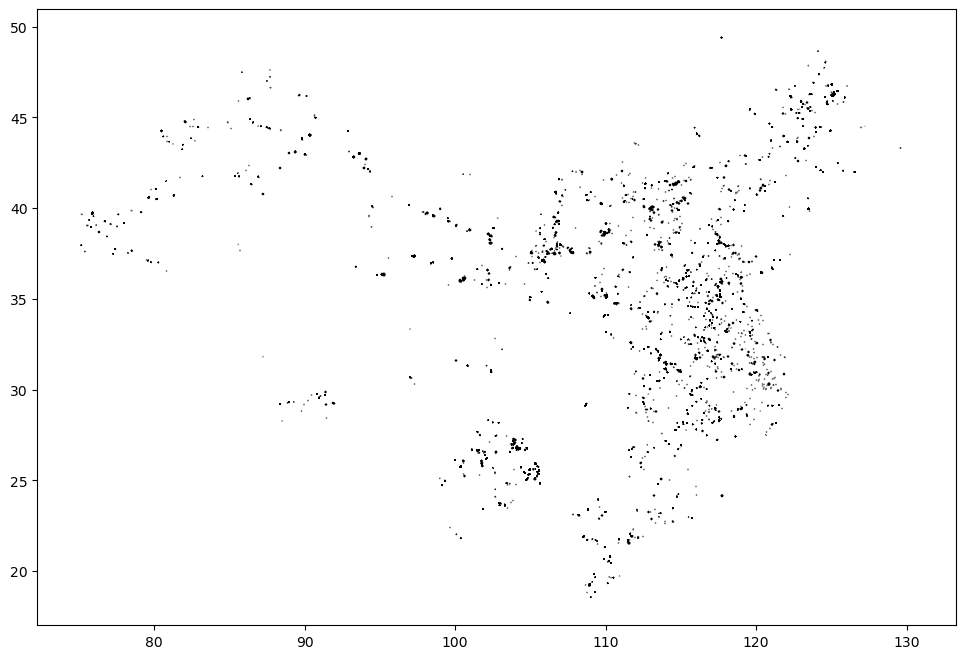

In [25]:
gdf.plot(figsize=(12, 8), edgecolor="black")


In [30]:
print(gdf['Area'].min())
print(gdf['Area'].max())

0.04002
104.23753


The minimum area is 0.04002 km² (~40,000 m²), and the maximum is 104.23753 km².
Installations at the lower end (0.04 km²) are likely to be small utility-scale or possibly large commercial/industrial rooftop solar, but are generally too large for typical household rooftop PV (which are usually <0.01 km²).The upper end (over 100 km²) is characteristic of large utility-scale solar farms.
Therefore, most of the data likely represents utility-scale solar installations, with some smaller sites possibly being large commercial or community solar, but not typical household PV.